# Importação e tratamento dos dados

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score

In [2]:
path = 'https://raw.githubusercontent.com/isabelaevangelista/Pratica-KDB/main/source/sales_data.csv'

In [3]:
dados = pd.read_csv(path, parse_dates = ['Date'], sep = ",") # importação da base de dados já definindo o tipo do campo Date

In [4]:
dados.head()

,Date,Region,Product,Price,Quantity Sold,Sales
0,2023-01-01,East,Product A,82.05,6,492.30
1,2023-01-02,West,Product A,28.01,17,476.17
2,2023-01-03,North,Product A,25.07,14,350.98
3,2023-01-04,East,Product E,19.41,17,329.97
4,2023-01-05,East,Product D,67.28,8,538.24


In [5]:
dados.shape

(1000, 6)

In [6]:
print("Data inicial: ", dados["Date"].min())
print("Data final: ", dados["Date"].max())

Data inicial:  2023-01-01 00:00:00
Data final:  2025-09-26 00:00:00


In [7]:
dados.isnull().sum() # conhecendo a base porque um dia sem vendas não é um problema

Date             0
Region           0
Product          0
Price            0
Quantity Sold    0
Sales            0
dtype: int64

In [8]:
dados.duplicated().sum() # verificando a existência de dados duplicados que atrapalhariam na previsão

0

In [9]:
dados.info() # verificando os tipos dos dados

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1000 non-null   datetime64[ns]
 1   Region         1000 non-null   object        
 2   Product        1000 non-null   object        
 3   Price          1000 non-null   float64       
 4   Quantity Sold  1000 non-null   int64         
 5   Sales          1000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 47.0+ KB


In [10]:
dados.head() # os nomes das colunas, no momento, não indicam nenhum tipo de problema futuro

,Date,Region,Product,Price,Quantity Sold,Sales
0,2023-01-01,East,Product A,82.05,6,492.30
1,2023-01-02,West,Product A,28.01,17,476.17
2,2023-01-03,North,Product A,25.07,14,350.98
3,2023-01-04,East,Product E,19.41,17,329.97
4,2023-01-05,East,Product D,67.28,8,538.24


In [11]:
# removendo a palavra 'Product' da coluna 'Product' porque não agrega nas consultas

def tratar_produto(produto):
  if produto != "":
    return produto[-1:]

In [12]:
dados['Product'] = dados['Product'].apply(tratar_produto).astype(str)

In [13]:
dados.head()

,Date,Region,Product,Price,Quantity Sold,Sales
0,2023-01-01,East,A,82.05,6,492.30
1,2023-01-02,West,A,28.01,17,476.17
2,2023-01-03,North,A,25.07,14,350.98
3,2023-01-04,East,E,19.41,17,329.97
4,2023-01-05,East,D,67.28,8,538.24


In [14]:
# dividindo o campo Date em ano, mês, dia e dia da semana para gerar análises extra

dados['Year'] = dados['Date'].dt.year
dados['Month'] = dados['Date'].dt.month
dados['Weekday'] = dados['Date'].dt.day_name()

In [15]:
# definindo a ordem dos dias da semana para agregar na formação de gráficos
# forma melhor de fazer isso?

dias_da_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [16]:
# aplicando a ordem dos dias da semana no dataframe

ordem_dias = pd.CategoricalDtype(categories=dias_da_semana, ordered=True)
dados['Weekday'] = dados['Weekday'].astype(ordem_dias)

In [17]:
dados.head()

,Date,Region,Product,Price,Quantity Sold,Sales,Year,Month,Weekday
0,2023-01-01,East,A,82.05,6,492.30,2023,1,Sunday
1,2023-01-02,West,A,28.01,17,476.17,2023,1,Monday
2,2023-01-03,North,A,25.07,14,350.98,2023,1,Tuesday
3,2023-01-04,East,E,19.41,17,329.97,2023,1,Wednesday
4,2023-01-05,East,D,67.28,8,538.24,2023,1,Thursday


In [18]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1000 non-null   datetime64[ns]
 1   Region         1000 non-null   object        
 2   Product        1000 non-null   object        
 3   Price          1000 non-null   float64       
 4   Quantity Sold  1000 non-null   int64         
 5   Sales          1000 non-null   float64       
 6   Year           1000 non-null   int32         
 7   Month          1000 non-null   int32         
 8   Weekday        1000 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(2), int32(2), int64(1), object(2)
memory usage: 56.1+ KB


# Análise exploratória

In [19]:
dados.describe() # para verificar média, totais, desvio padrão e quartis

,Date,Price,Quantity Sold,Sales,Year,Month
count,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2024-05-14 12:00:00,55.417260,10.103000,562.475330,2023.904000,6.100000
min,2023-01-01 00:00:00,10.290000,1.000000,11.730000,2023.000000,1.000000
25%,2023-09-07 18:00:00,32.347500,5.000000,208.627500,2023.000000,3.000000
50%,2024-05-14 12:00:00,56.520000,10.000000,448.470000,2024.000000,6.000000
75%,2025-01-19 06:00:00,77.345000,15.000000,829.900000,2025.000000,9.000000
max,2025-09-26 00:00:00,99.950000,19.000000,1891.260000,2025.000000,12.000000
std,NaN,25.902891,5.547357,428.443008,0.790828,3.307407


In [20]:
dados.head()

,Date,Region,Product,Price,Quantity Sold,Sales,Year,Month,Weekday
0,2023-01-01,East,A,82.05,6,492.30,2023,1,Sunday
1,2023-01-02,West,A,28.01,17,476.17,2023,1,Monday
2,2023-01-03,North,A,25.07,14,350.98,2023,1,Tuesday
3,2023-01-04,East,E,19.41,17,329.97,2023,1,Wednesday
4,2023-01-05,East,D,67.28,8,538.24,2023,1,Thursday


In [21]:
dados.groupby('Product')['Price'].mean() # média de preços por produto

Product
A    53.625117
B    55.334851
C    57.080927
D    54.607544
E    56.354019
Name: Price, dtype: float64

In [22]:
dados.groupby('Product')['Quantity Sold'].sum() # total de vendas por produto

Product
A    2227
B    1978
C    2055
D    1689
E    2154
Name: Quantity Sold, dtype: int64

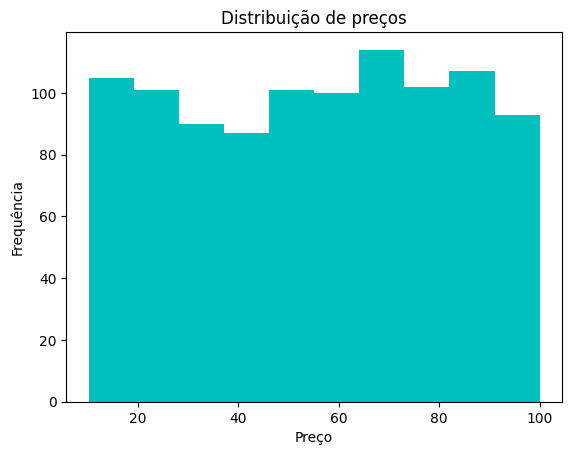

In [23]:
plt.hist(dados['Price'], color='c')

plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.title('Distribuição de preços')
plt.show()

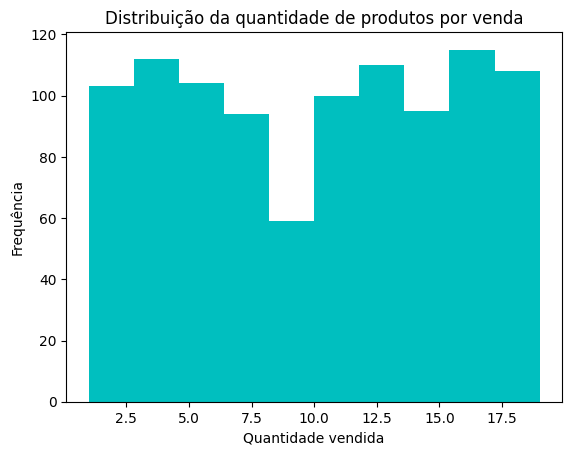

In [24]:
plt.hist(dados['Quantity Sold'], color='c')

plt.xlabel('Quantidade vendida')
plt.ylabel('Frequência')
plt.title('Distribuição da quantidade de produtos por venda')
plt.show()

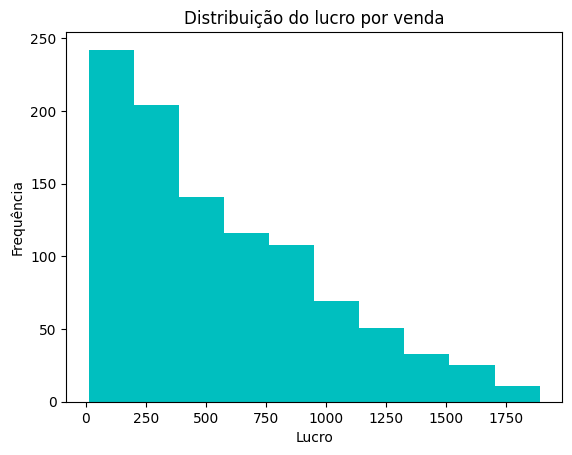

In [25]:
plt.hist(dados['Sales'], color='c')

plt.xlabel('Lucro')
plt.ylabel('Frequência')
plt.title('Distribuição do lucro por venda')
plt.show()

# Análise de dados

In [26]:
dados.head()

,Date,Region,Product,Price,Quantity Sold,Sales,Year,Month,Weekday
0,2023-01-01,East,A,82.05,6,492.30,2023,1,Sunday
1,2023-01-02,West,A,28.01,17,476.17,2023,1,Monday
2,2023-01-03,North,A,25.07,14,350.98,2023,1,Tuesday
3,2023-01-04,East,E,19.41,17,329.97,2023,1,Wednesday
4,2023-01-05,East,D,67.28,8,538.24,2023,1,Thursday


## Análises gerais com o valor de vendas

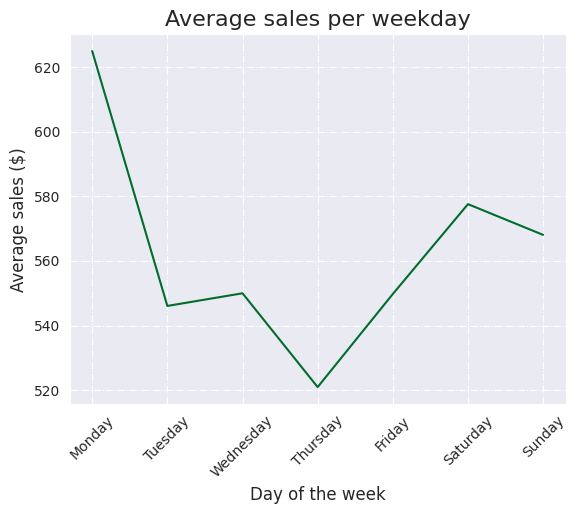

In [77]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Weekday')['Sales'].mean(), color = '#006d2c')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_ylabel('Average sales ($)', fontsize = 12)
ax.set_title('Average sales per weekday', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(rotation=45)

plt.show()

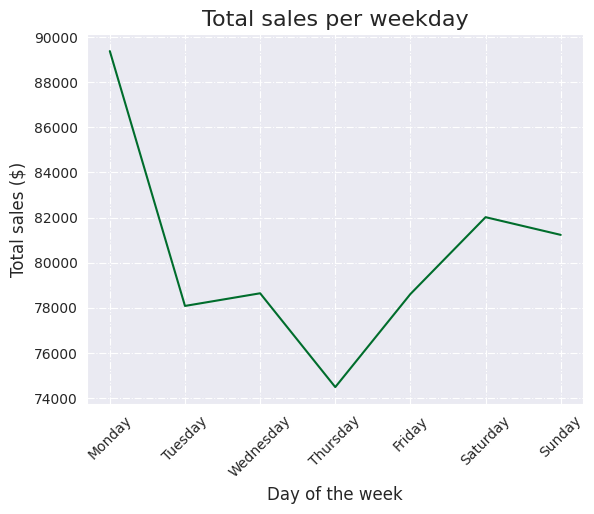

In [29]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Weekday')['Sales'].sum(), color = '#006d2c')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_ylabel('Total sales ($)', fontsize = 12)
ax.set_title('Total sales per weekday', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(rotation=45)

plt.show()

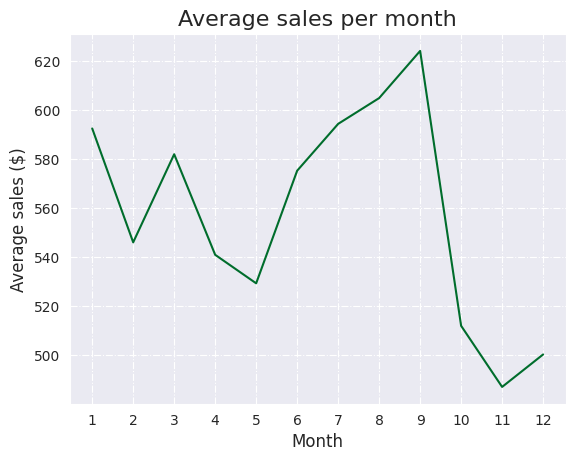

In [30]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Month')['Sales'].mean(), color = '#006d2c')

plt.xticks(ticks = dados['Month'].unique())

ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Average sales ($)', fontsize = 12)
ax.set_title('Average sales per month', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

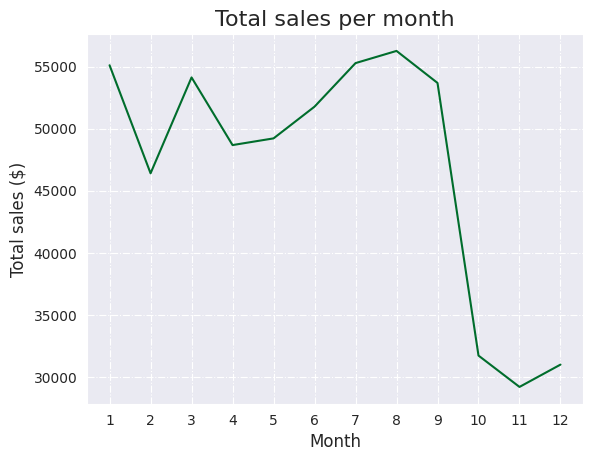

In [31]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Month')['Sales'].sum(), color = '#006d2c')

plt.xticks(ticks = dados['Month'].unique())

ax.set_xlabel('Month', fontsize = 12)
ax.set_ylabel('Total sales ($)', fontsize = 12)
ax.set_title('Total sales per month', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

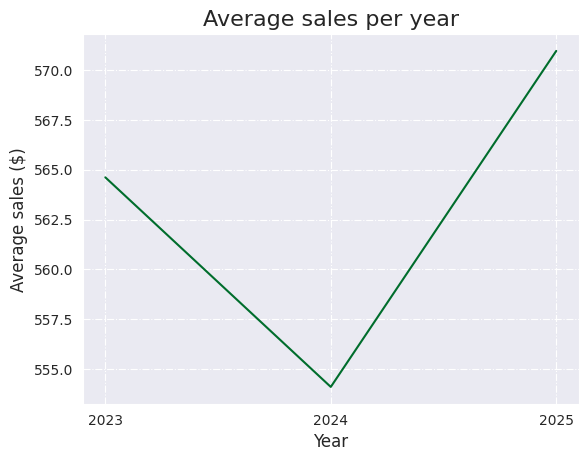

In [32]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Year')['Sales'].mean(), color = '#006d2c')

plt.xticks(ticks = dados['Year'].unique())

ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Average sales ($)', fontsize = 12)
ax.set_title('Average sales per year', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

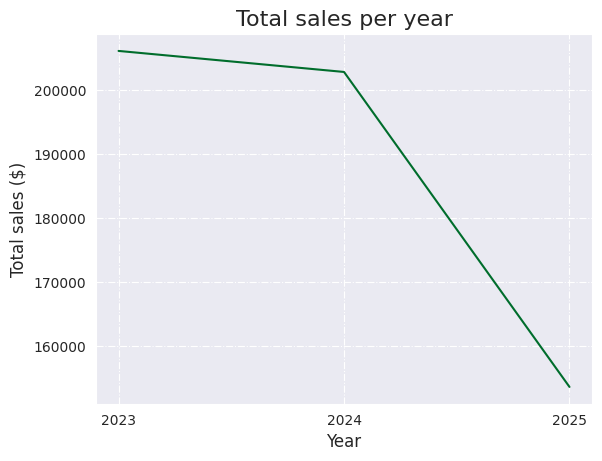

In [33]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Year')['Sales'].sum(), color = '#006d2c')

plt.xticks(ticks = dados['Year'].unique())

ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Total sales ($)', fontsize = 12)
ax.set_title('Total sales per year', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

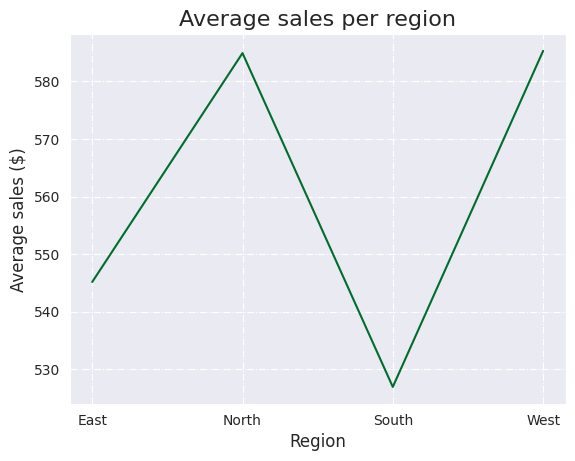

In [34]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Region')['Sales'].mean(), color = '#006d2c')

ax.set_xlabel('Region', fontsize = 12)
ax.set_ylabel('Average sales ($)', fontsize = 12)
ax.set_title('Average sales per region', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

## Análises gerais com a quantidade de vendas

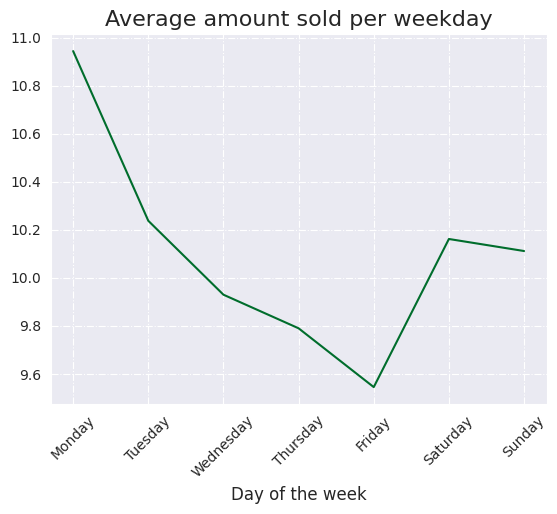

In [35]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Weekday')['Quantity Sold'].mean(), color = '#006d2c')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_title('Average amount sold per weekday', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(rotation=45)

plt.show()

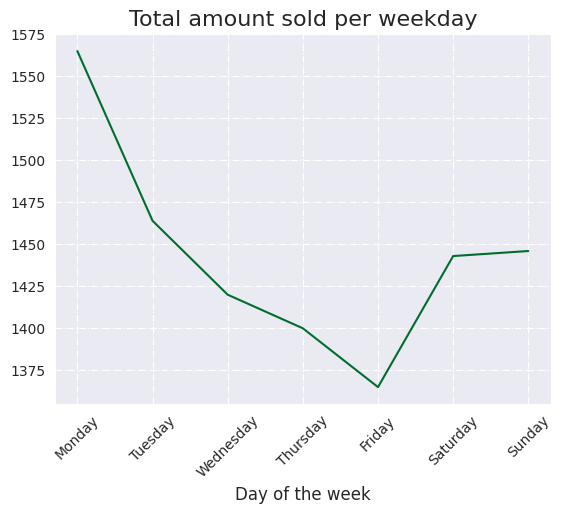

In [36]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Weekday')['Quantity Sold'].sum(), color = '#006d2c')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_title('Total amount sold per weekday', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(rotation=45)

plt.show()

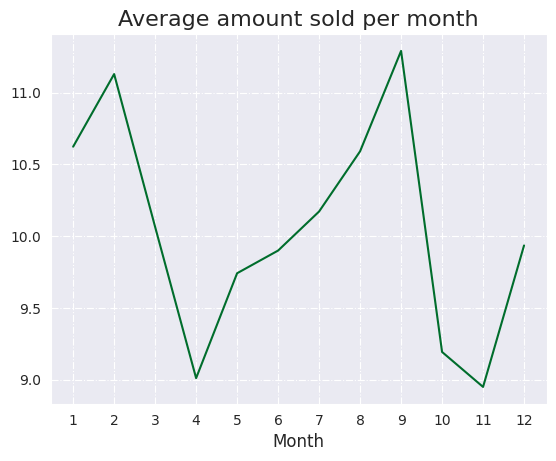

In [37]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Month')['Quantity Sold'].mean(), color = '#006d2c')

ax.set_xlabel('Month', fontsize = 12)
ax.set_title('Average amount sold per month', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(ticks = dados['Month'].unique())

plt.show()

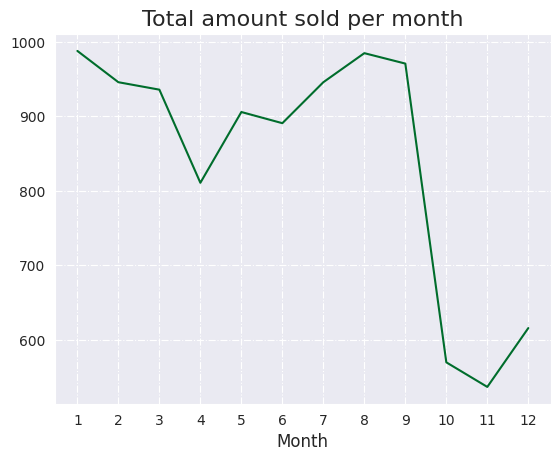

In [38]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Month')['Quantity Sold'].sum(), color = '#006d2c')

ax.set_xlabel('Month', fontsize = 12)
ax.set_title('Total amount sold per month', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(ticks = dados['Month'].unique())

plt.show()

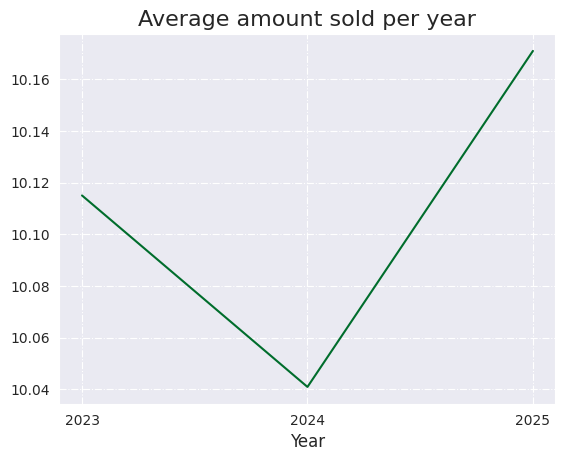

In [39]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Year')['Quantity Sold'].mean(), color = '#006d2c')

ax.set_xlabel('Year', fontsize = 12)
ax.set_title('Average amount sold per year', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(ticks = dados['Year'].unique())

plt.show()

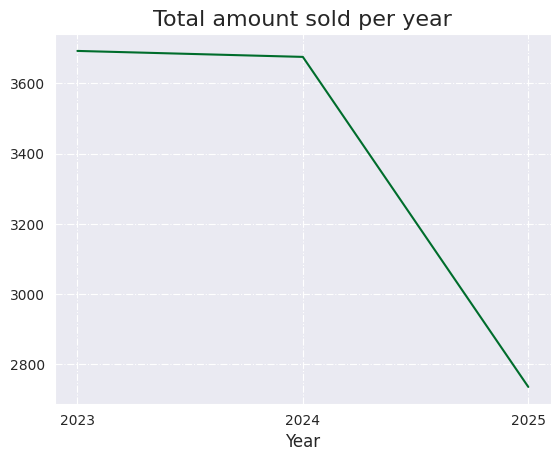

In [40]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Year')['Quantity Sold'].sum(), color = '#006d2c')

ax.set_xlabel('Year', fontsize = 12)
ax.set_title('Total amount sold per year', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.xticks(ticks = dados['Year'].unique())

plt.show()

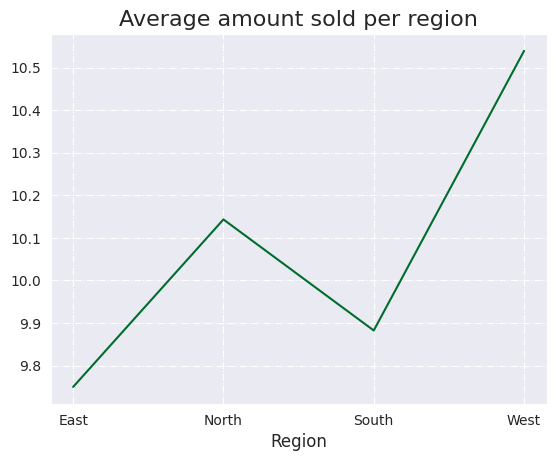

In [41]:
fig, ax = plt.subplots()

ax.plot(dados.groupby('Region')['Quantity Sold'].mean(), color = '#006d2c')

ax.set_xlabel('Region', fontsize = 12)
ax.set_title('Average amount sold per region', fontsize = 16)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

# Análises específicas

In [42]:
produto_a = dados[dados['Product'] == 'A']
produto_b = dados[dados['Product'] == 'B']
produto_c = dados[dados['Product'] == 'C']
produto_d = dados[dados['Product'] == 'D']
produto_e = dados[dados['Product'] == 'E']

In [43]:
produto_a.head()

,Date,Region,Product,Price,Quantity Sold,Sales,Year,Month,Weekday
0,2023-01-01,East,A,82.05,6,492.30,2023,1,Sunday
1,2023-01-02,West,A,28.01,17,476.17,2023,1,Monday
2,2023-01-03,North,A,25.07,14,350.98,2023,1,Tuesday
14,2023-01-15,West,A,40.55,17,689.35,2023,1,Sunday
21,2023-01-22,North,A,67.92,13,882.96,2023,1,Sunday


## Relação produto X região


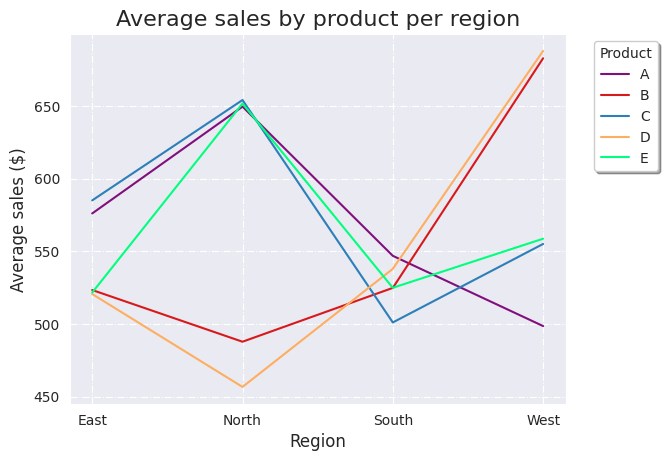

In [44]:
fig, ax = plt.subplots()

ax.plot(produto_a.groupby('Region')['Sales'].mean(), label= 'A', color = '#810f7c')
ax.plot(produto_b.groupby('Region')['Sales'].mean(), label= 'B', color = '#d7191c')
ax.plot(produto_c.groupby('Region')['Sales'].mean(), label= 'C', color = '#2c7fb8')
ax.plot(produto_d.groupby('Region')['Sales'].mean(), label= 'D', color = '#fdae61')
ax.plot(produto_e.groupby('Region')['Sales'].mean(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Region', fontsize = 12)
ax.set_ylabel('Average sales ($)', fontsize = 12)
ax.set_title('Average sales by product per region', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

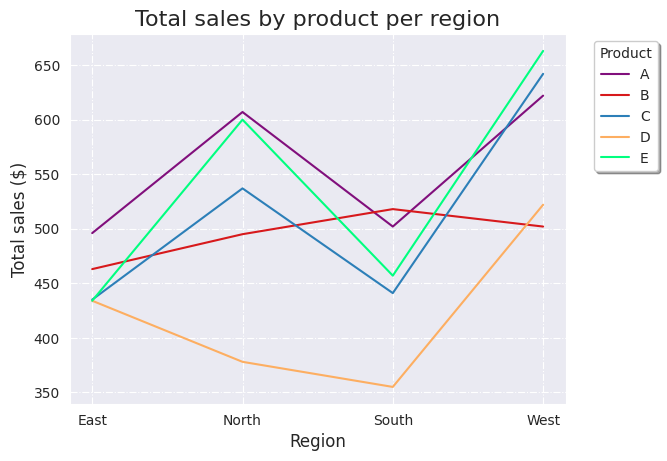

In [45]:
fig, ax = plt.subplots()

ax.plot(produto_a.groupby('Region')['Quantity Sold'].sum(), label= 'A', color = '#810f7c')
ax.plot(produto_b.groupby('Region')['Quantity Sold'].sum(), label= 'B', color = '#d7191c')
ax.plot(produto_c.groupby('Region')['Quantity Sold'].sum(), label= 'C', color = '#2c7fb8')
ax.plot(produto_d.groupby('Region')['Quantity Sold'].sum(), label= 'D', color = '#fdae61')
ax.plot(produto_e.groupby('Region')['Quantity Sold'].sum(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Region', fontsize = 12)
ax.set_ylabel('Total sales ($)', fontsize = 12)
ax.set_title('Total sales by product per region', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

## Produtos mais vendidos

In [46]:
dados.groupby('Product')['Sales'].sum().sort_values(ascending=False).head(3)

Product
A    120588.59
E    118729.01
C    117639.92
Name: Sales, dtype: float64

In [47]:
dados.groupby('Product')['Quantity Sold'].sum().sort_values(ascending=False).head(3)

Product
A    2227
E    2154
C    2055
Name: Quantity Sold, dtype: int64

## Preços médios e correlação entre os preços e as quantidades

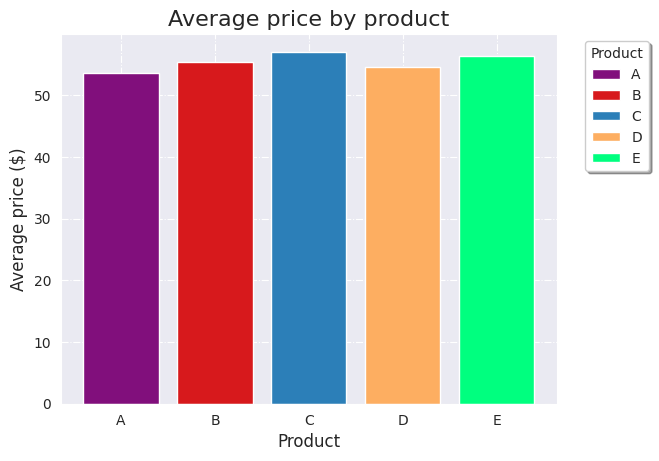

In [49]:
fig, ax = plt.subplots()

ax.bar(produto_a['Product'].unique(), produto_a['Price'].mean(), label= 'A', color = '#810f7c')
ax.bar(produto_b['Product'].unique(), produto_b['Price'].mean(), label= 'B', color = '#d7191c')
ax.bar(produto_c['Product'].unique(), produto_c['Price'].mean(), label= 'C', color = '#2c7fb8')
ax.bar(produto_d['Product'].unique(), produto_d['Price'].mean(), label= 'D', color = '#fdae61')
ax.bar(produto_e['Product'].unique(), produto_e['Price'].mean(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Product', fontsize = 12)
ax.set_ylabel('Average price ($)', fontsize = 12)
ax.set_title('Average price by product', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

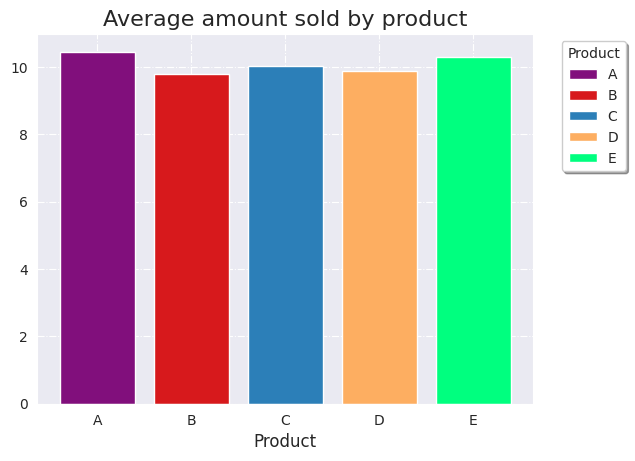

In [50]:
fig, ax = plt.subplots()

ax.bar(produto_a['Product'].unique(), produto_a['Quantity Sold'].mean(), label= 'A', color = '#810f7c')
ax.bar(produto_b['Product'].unique(), produto_b['Quantity Sold'].mean(), label= 'B', color = '#d7191c')
ax.bar(produto_c['Product'].unique(), produto_c['Quantity Sold'].mean(), label= 'C', color = '#2c7fb8')
ax.bar(produto_d['Product'].unique(), produto_d['Quantity Sold'].mean(), label= 'D', color = '#fdae61')
ax.bar(produto_e['Product'].unique(), produto_e['Quantity Sold'].mean(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Product', fontsize = 12)
ax.set_title('Average amount sold by product', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

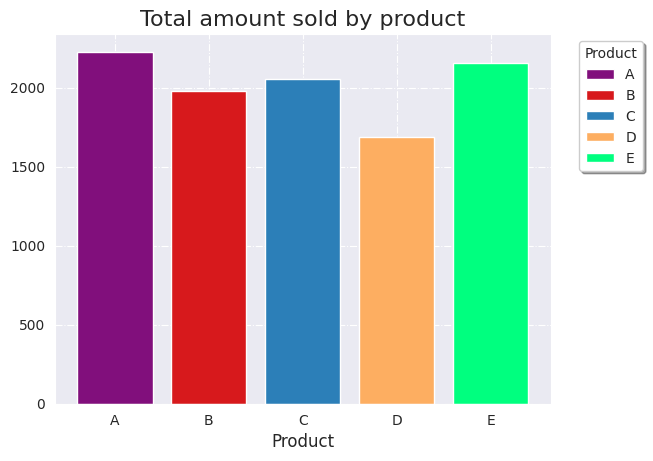

In [51]:
fig, ax = plt.subplots()

ax.bar(produto_a['Product'].unique(), produto_a['Quantity Sold'].sum(), label= 'A', color = '#810f7c')
ax.bar(produto_b['Product'].unique(), produto_b['Quantity Sold'].sum(), label= 'B', color = '#d7191c')
ax.bar(produto_c['Product'].unique(), produto_c['Quantity Sold'].sum(), label= 'C', color = '#2c7fb8')
ax.bar(produto_d['Product'].unique(), produto_d['Quantity Sold'].sum(), label= 'D', color = '#fdae61')
ax.bar(produto_e['Product'].unique(), produto_e['Quantity Sold'].sum(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Product', fontsize = 12)
ax.set_title('Total amount sold by product', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

## Variação de vendas por semana e análise temporal

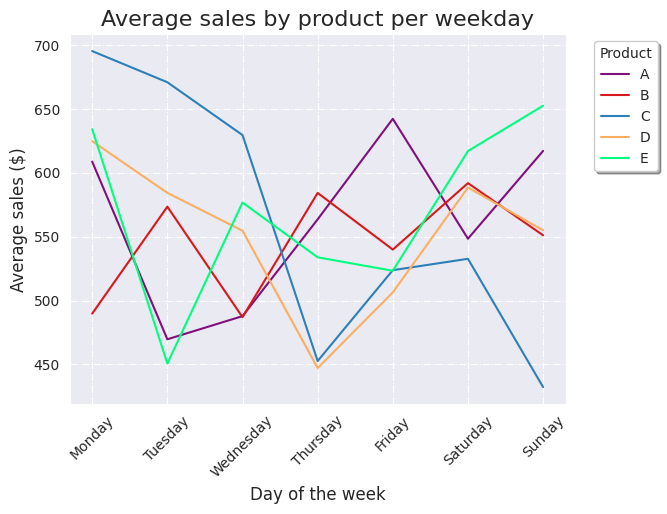

In [52]:
fig, ax = plt.subplots()

ax.plot(produto_a.groupby('Weekday')['Sales'].mean(), label= 'A', color = '#810f7c')
ax.plot(produto_b.groupby('Weekday')['Sales'].mean(), label= 'B', color = '#d7191c')
ax.plot(produto_c.groupby('Weekday')['Sales'].mean(), label= 'C', color = '#2c7fb8')
ax.plot(produto_d.groupby('Weekday')['Sales'].mean(), label= 'D', color = '#fdae61')
ax.plot(produto_e.groupby('Weekday')['Sales'].mean(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_ylabel('Average sales ($)', fontsize = 12)
ax.set_title('Average sales by product per weekday', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')

plt.xticks(rotation=45)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

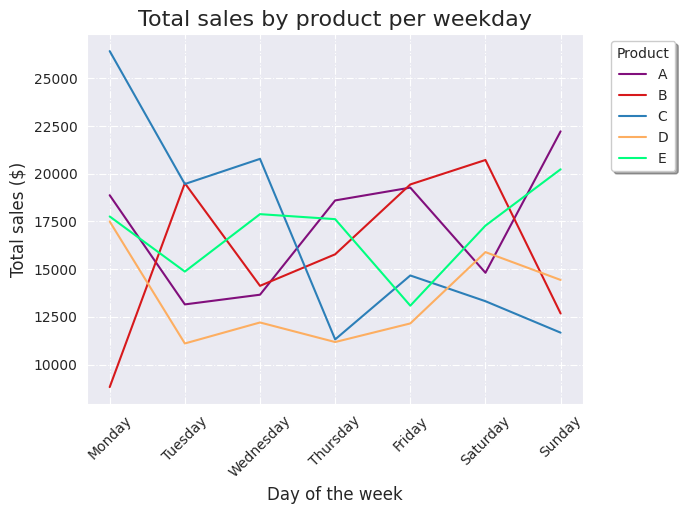

In [53]:
fig, ax = plt.subplots()

ax.plot(produto_a.groupby('Weekday')['Sales'].sum(), label= 'A', color = '#810f7c')
ax.plot(produto_b.groupby('Weekday')['Sales'].sum(), label= 'B', color = '#d7191c')
ax.plot(produto_c.groupby('Weekday')['Sales'].sum(), label= 'C', color = '#2c7fb8')
ax.plot(produto_d.groupby('Weekday')['Sales'].sum(), label= 'D', color = '#fdae61')
ax.plot(produto_e.groupby('Weekday')['Sales'].sum(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_ylabel('Total sales ($)', fontsize = 12)
ax.set_title('Total sales by product per weekday', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
plt.xticks(rotation=45)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

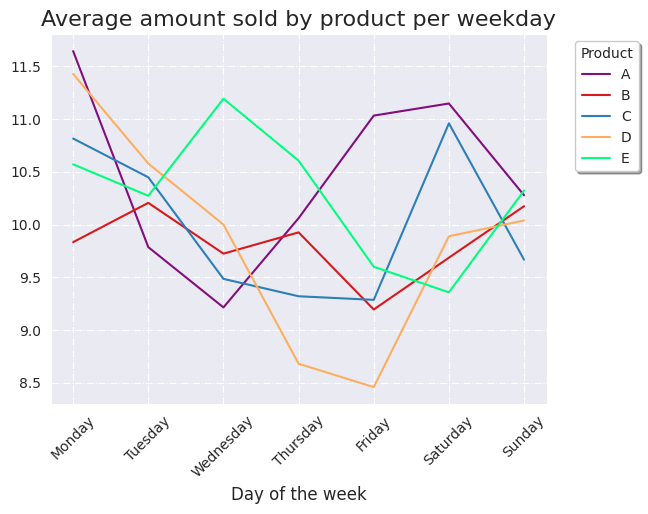

In [54]:
fig, ax = plt.subplots()

ax.plot(produto_a.groupby('Weekday')['Quantity Sold'].mean(), label= 'A', color = '#810f7c')
ax.plot(produto_b.groupby('Weekday')['Quantity Sold'].mean(), label= 'B', color = '#d7191c')
ax.plot(produto_c.groupby('Weekday')['Quantity Sold'].mean(), label= 'C', color = '#2c7fb8')
ax.plot(produto_d.groupby('Weekday')['Quantity Sold'].mean(), label= 'D', color = '#fdae61')
ax.plot(produto_e.groupby('Weekday')['Quantity Sold'].mean(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_title('Average amount sold by product per weekday', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
plt.xticks(rotation=45)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

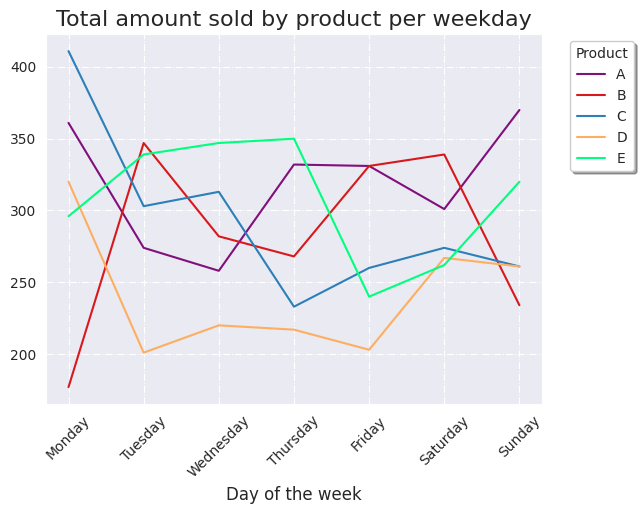

In [55]:
fig, ax = plt.subplots()

ax.plot(produto_a.groupby('Weekday')['Quantity Sold'].sum(), label= 'A', color = '#810f7c')
ax.plot(produto_b.groupby('Weekday')['Quantity Sold'].sum(), label= 'B', color = '#d7191c')
ax.plot(produto_c.groupby('Weekday')['Quantity Sold'].sum(), label= 'C', color = '#2c7fb8')
ax.plot(produto_d.groupby('Weekday')['Quantity Sold'].sum(), label= 'D', color = '#fdae61')
ax.plot(produto_e.groupby('Weekday')['Quantity Sold'].sum(), label= 'E', color = '#00FF7F')

ax.set_xlabel('Day of the week', fontsize = 12)
ax.set_title('Total amount sold by product per weekday', fontsize = 16)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), shadow = True, facecolor = 'white', title = 'Product')
plt.xticks(rotation=45)
sns.set_style("darkgrid", {'grid.linestyle': '-.'})

plt.show()

In [56]:
dados_sd = dados[['Date', 'Sales']].set_index('Date')

In [57]:
resultados = seasonal_decompose(dados_sd)

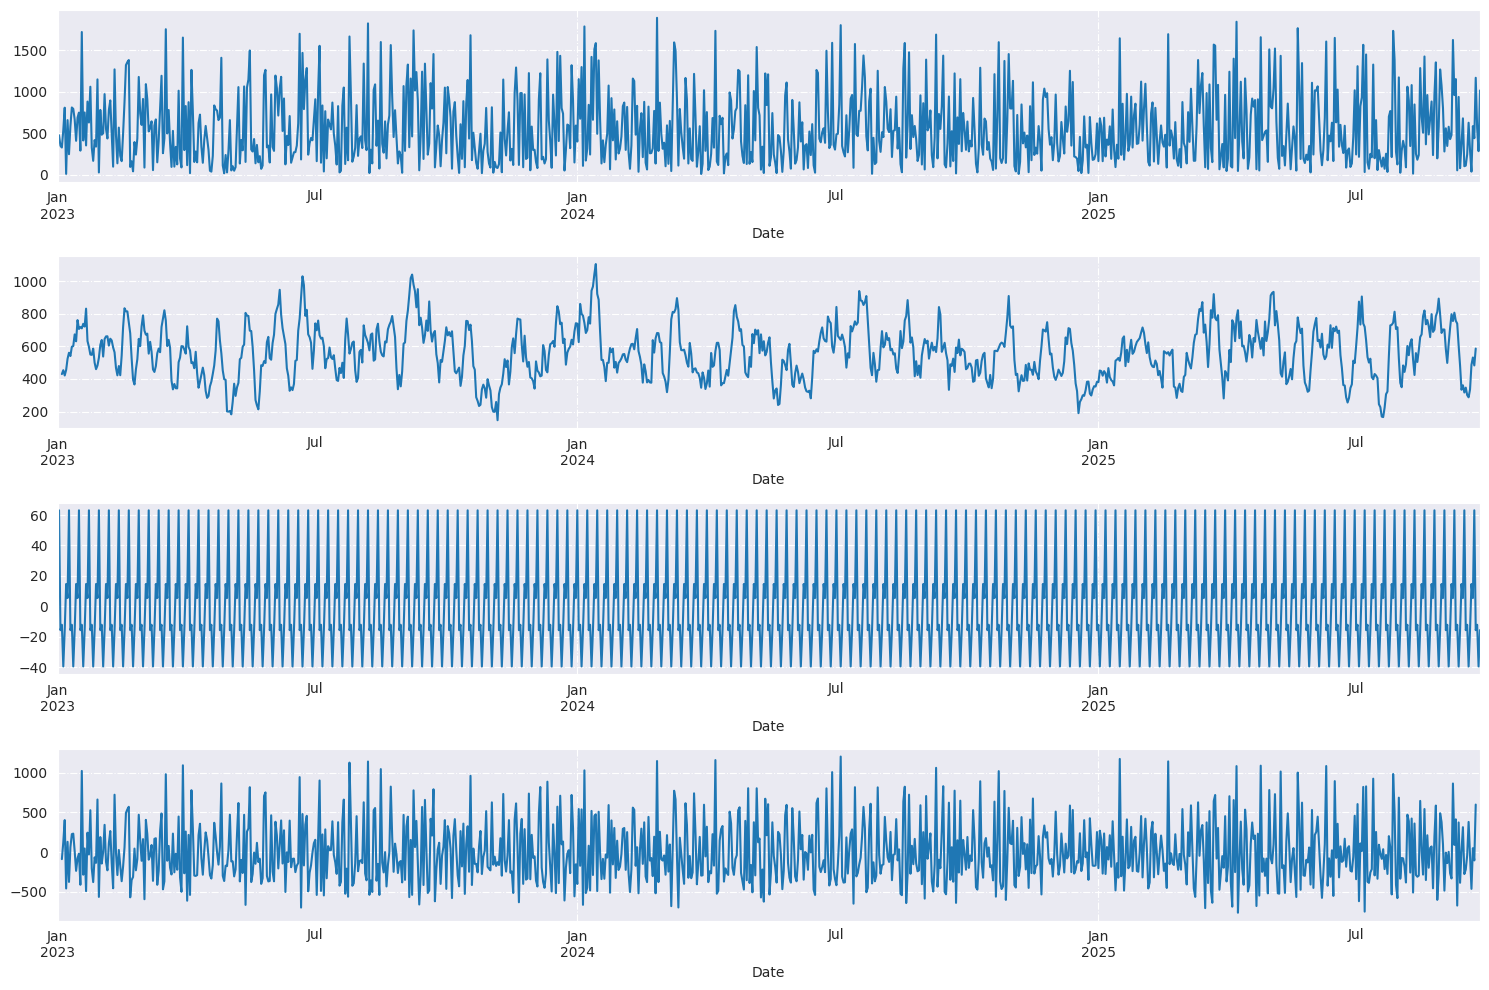

In [58]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

# Modelo de regressão linear

In [59]:
dados_prev = pd.read_csv(path, parse_dates = ['Date'], sep = ",")
# deve ser usado o df original pois dados está ordenado de acordo com o dia da semana e isso pode atraplhar na análise temporal e previsão

In [60]:
dados_prev = dados_prev[['Region', 'Price', 'Quantity Sold']]

In [61]:
encoder = LabelEncoder() # para transformar os campos somente em 0 e 1

In [62]:
dados_prev['Region'] = encoder.fit_transform(dados_prev['Region'])

In [63]:
dados_prev.head()

,Region,Price,Quantity Sold
0,0,82.05,6
1,3,28.01,17
2,1,25.07,14
3,0,19.41,17
4,0,67.28,8


In [64]:
x = dados_prev[['Region', 'Price']]

y = dados_prev['Quantity Sold']

In [65]:
lr = LinearRegression()

In [66]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 146)

In [67]:
lr.fit(x_train,y_train)

LinearRegression()

In [68]:
y_pred = lr.predict(x_test)

In [69]:
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Absolute Error (MAE)',MAE)
print('Erro Quadrático Médio (MSE)',MSE)
print('Coenficiente r²',r2)

MAE 4.622064714390479
MSE 29.002945137884193
r² -0.001278922384051251


In [70]:
scaler = StandardScaler() # tentativa de normalização dos dados para verificar se o modelo se desenvolve melhor

In [71]:
dados_prev_std = scaler.fit_transform(dados_prev)

In [72]:
scaler.fit(x_train)

StandardScaler()

In [73]:
# padronizando os dados
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [74]:
lr.fit(x_train_scaled,y_train)

LinearRegression()

In [75]:
y_pred_scaled = lr.predict(x_test_scaled)

In [76]:
r_sq_var = lr.score(x, y)
mae_var = mean_absolute_error(y_test, y_pred_scaled)

print('Coeficiente de Determinação (R²):', r_sq_var)
print('Mean Absolute Error: ', mae_var)

Coeficiente de Determinação (R²): -0.2115100103323
Mean Absolute Error:  4.622064714390479


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
